In [1]:
import random

import torch
from torchvision.transforms import v2 as transforms

import lightning as pl
from lightning.pytorch.callbacks.model_summary import summarize
from lightning.pytorch.callbacks import ModelCheckpoint

from keyrover.datasets import *
from keyrover.ml import get_device, BinarySegmentationModel
from keyrover import imshow

In [2]:
device = get_device()
device

'mps'

In [3]:
image_paths = get_dataset_paths()
len(image_paths)

2004

In [4]:
mean, std = get_dataset_norm_params(version=3)
mean, std

(array([0.26772413, 0.28418145, 0.28728417]),
 array([0.24711585, 0.24890053, 0.25881228]))

In [5]:
train_paths, test_paths, valid_paths = split_train_test_valid(image_paths, 0.8, 0.1)

SIZE = (480, 640)

train_dataset = BinaryKeyboardSegmentationDataset(train_paths, size=SIZE)
valid_dataset = BinaryKeyboardSegmentationDataset(valid_paths, size=SIZE)
test_dataset = BinaryKeyboardSegmentationDataset(test_paths, size=SIZE)

len(train_dataset), len(valid_dataset), len(test_dataset)

  0%|          | 0/1403 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

(1403, 200, 401)

In [6]:
train_dataset.set_transforms([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAffine(degrees=30, shear=30, translate=(0.25, 0.25)),
    transforms.RandomPerspective(distortion_scale=0.25, p=0.5),
    # transforms.RandomErasing(p=0.5),
])

train_dataset.set_augmentations([
    # transforms.RandomChannelPermutation(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.GaussianNoise(sigma=0.01),
    transforms.RandomApply([transforms.GaussianNoise(sigma=0.01)], p=0.5),
    transforms.Normalize(mean, std),
])

valid_dataset.set_augmentations([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

test_dataset.set_augmentations([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

1191 (3, 480, 640)


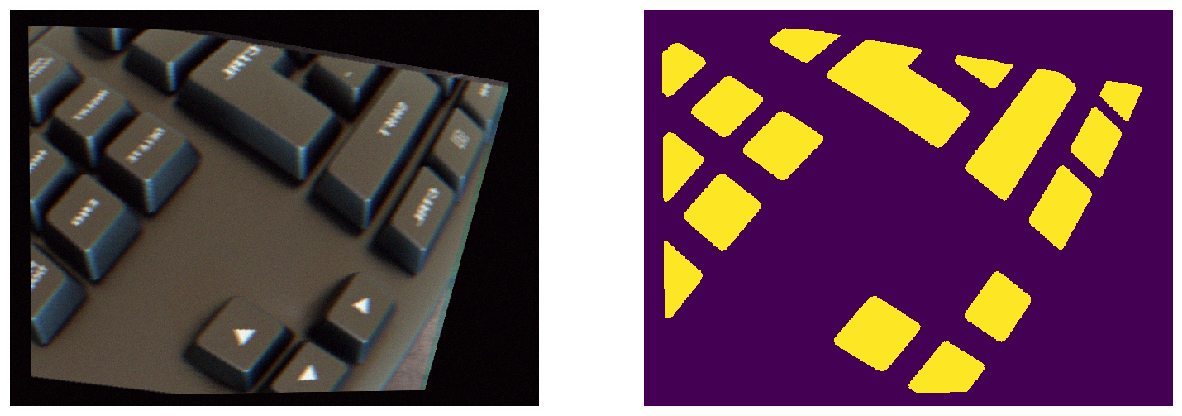

In [7]:
i = random.randint(0, len(train_dataset) - 1)
img, mask = train_dataset[i]

print(i, tuple(img.shape))
imshow(img, mask, figsize=(15, 30))

In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

dl_kwargs = {"batch_size": BATCH_SIZE, "num_workers": 2, "persistent_workers": True, "pin_memory": True}

train_dataloader = DataLoader(train_dataset, **dl_kwargs, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, **dl_kwargs)
test_dataloader = DataLoader(test_dataset, **dl_kwargs)

In [9]:
img, mask = next(iter(train_dataloader))
img.dtype, mask.dtype

(torch.float32, torch.bool)

In [ ]:
import wandb
from lightning.pytorch.loggers import WandbLogger

wandb.login()

In [ ]:
ARCH = "unet"
BACKBONE = "timm-regnetx_002"

LEARNING_RATE = 2e-4

wandb.finish()
model = BinarySegmentationModel(ARCH, BACKBONE, in_channels=3, out_classes=1, encoder_weights="imagenet", lr=LEARNING_RATE)
model

In [ ]:
summarize(model)

In [ ]:
EPOCHS = 100

PROFILE = False
profiler = "advanced" if PROFILE else None

logger = WandbLogger(project="mrover-keyboard-region-segmentation")
# logger.watch(model, log="all", log_freq=len(train_dataloader))

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(log_every_n_steps=1, logger=logger, max_time="00:08:00:00",
                     callbacks=[checkpoint_callback], profiler=profiler)
wandb.define_metric(f"val_loss", summary="min")
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

In [ ]:
torch.save(model.state_dict(), f"models/binary_segmentation/{wandb.run.name}-{ARCH}-{BACKBONE}.pt")